# Setup

In this section, we initiate our environment by importing the essential libraries and modules and configuring necessary settings for the analysis.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

import xgboost
import lightgbm

from flaml import AutoML as flaml_AutoML
from flaml.automl.data import get_output_from_log
from supervised.automl import AutoML as mljar_AutoML

warnings.filterwarnings("ignore", category=FutureWarning)

# Data

### Data Loading

Here, we fetch our primary dataset for analysis. It's always a good practice to first examine the raw data to understand its initial structure.

In [2]:
df_original = pd.read_csv("DataTrain_Preliminary.csv", delimiter=";")
df_original

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack
0,0,tcp,private,SH,0,0,0,0,0,0,...,1,0.01,0.94,0.95,0,0.95,1,0,0,nmap
1,0,tcp,private,S0,0,0,0,0,0,0,...,5,0.02,0.08,0.00,0,1.00,1,0,0,neptune
2,0,tcp,http,SF,285,3623,0,0,0,0,...,228,1.00,0.00,0.01,*,0.00,0,0,0,normal
3,0,tcp,http,SF,232,584,0,0,0,0,...,255,1.00,0.00,0.17,*,0.00,0,0,0,normal
4,1,tcp,smtp,SF,1080,327,0,0,0,0,...,154,0.58,0.02,0.00,*,0.00,0,0,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112441,0,tcp,http,REJ,0,0,0,0,0,0,...,255,1.00,0.00,0.14,*,0.00,0,*,*,normal
112442,0,tcp,http,SF,309,758,0,0,0,0,...,255,1.00,0.00,0.02,*,0.02,*,0,0,normal
112443,0,tcp,http,SF,363,721,0,0,0,0,...,255,1.00,0.00,0.00,0,0.00,0,0,0,normal
112444,0,tcp,discard,RSTO,0,0,0,0,0,0,...,7,0.03,0.06,0.00,0,0.00,0,1,1,neptune


In [3]:
print(f"There are {df_original.shape[0]} rows and {df_original.shape[1]} columns")

There are 112446 rows and 42 columns


To maintain the integrity and quality of our data, we replace placeholders such as `*` and `99999` with `NaN` values. Furthermore, we attempt to convert columns to float types where possible, ensuring numerical operations can be seamlessly performed.

In [4]:
df = df_original.copy()
df = df.replace("*", np.nan)
df = df.replace("99999", np.nan)

for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except ValueError:
        pass

df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack
0,0.0,tcp,private,SH,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.01,0.94,0.95,0.0,0.95,1.0,0.0,0.0,nmap
1,0.0,tcp,private,S0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.02,0.08,0.00,0.0,1.00,1.0,0.0,0.0,neptune
2,0.0,tcp,http,SF,285.0,3623.0,0.0,0.0,0.0,0.0,...,228.0,1.00,0.00,0.01,NaN,0.00,0.0,0.0,0.0,normal
3,0.0,tcp,http,SF,232.0,584.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.17,NaN,0.00,0.0,0.0,0.0,normal
4,1.0,tcp,smtp,SF,1080.0,327.0,0.0,0.0,0.0,0.0,...,154.0,0.58,0.02,0.00,NaN,0.00,0.0,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112441,0.0,tcp,http,REJ,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.14,NaN,0.00,0.0,NaN,NaN,normal
112442,0.0,tcp,http,SF,309.0,758.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.02,NaN,0.02,NaN,0.0,0.0,normal
112443,0.0,tcp,http,SF,363.0,721.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,normal
112444,0.0,tcp,discard,RSTO,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.03,0.06,0.00,0.0,0.00,0.0,1.0,1.0,neptune


By setting the foundation with a consistent random state and generating a comprehensive overview of the dataset, we can observe column data types, missing values, uniqueness of entries, and sample data points. From the presented overview, it's evident that there are missing values in some variables. However, we opt to retain them for now as XGBoost possesses a built-in feature to adeptly handle missing values.

In [5]:
random_state = 42
np.random.seed(random_state)

df_overview = pd.DataFrame({
    "type":df.dtypes.values,
    "null":df.isnull().sum().values,
    "null_percentage":df.isnull().sum().values / len(df) * 100,
    "unique":[df[i].nunique() for i in df.columns],
    "sample":[list(pd.Series(df.dropna()[i].unique()).sample())[0] for i in df.columns]
}).set_index(df.isnull().sum().index).sort_values("null", ascending=False)

df_overview

,type,null,null_percentage,unique,sample
same_srv_rate,float64,42430,37.733668,2,0.0
diff_srv_rate,float64,42242,37.566476,2,0.0
dst_host_srv_diff_host_rate,float64,34559,30.733863,2,0.0
srv_diff_host_rate,float64,18379,16.344734,2,1.0
dst_host_rerror_rate,float64,11427,10.162211,2,0.0
dst_host_srv_rerror_rate,float64,5867,5.217616,2,1.0
dst_host_srv_serror_rate,float64,5852,5.204276,2,1.0
serror_rate,float64,4717,4.194902,2,0.0
rerror_rate,float64,3919,3.485228,2,1.0
srv_serror_rate,float64,2876,2.557672,2,1.0


### Data Exploration

The `type_of_attack` variable is pivotal to our analysis, being our target. By visualizing its distribution, we gain insights into the prevalence of different attack types. As illustrated in the plot, there's a noticeable imbalance in the dataset. Specifically, the majority of instances predominantly fall under `normal` or `neptune` categories. To address this imbalance during model training and evaluation, we will utilize the `stratify` parameter during the train-test split, ensuring that the class distribution remains consistent between the training and test datasets.

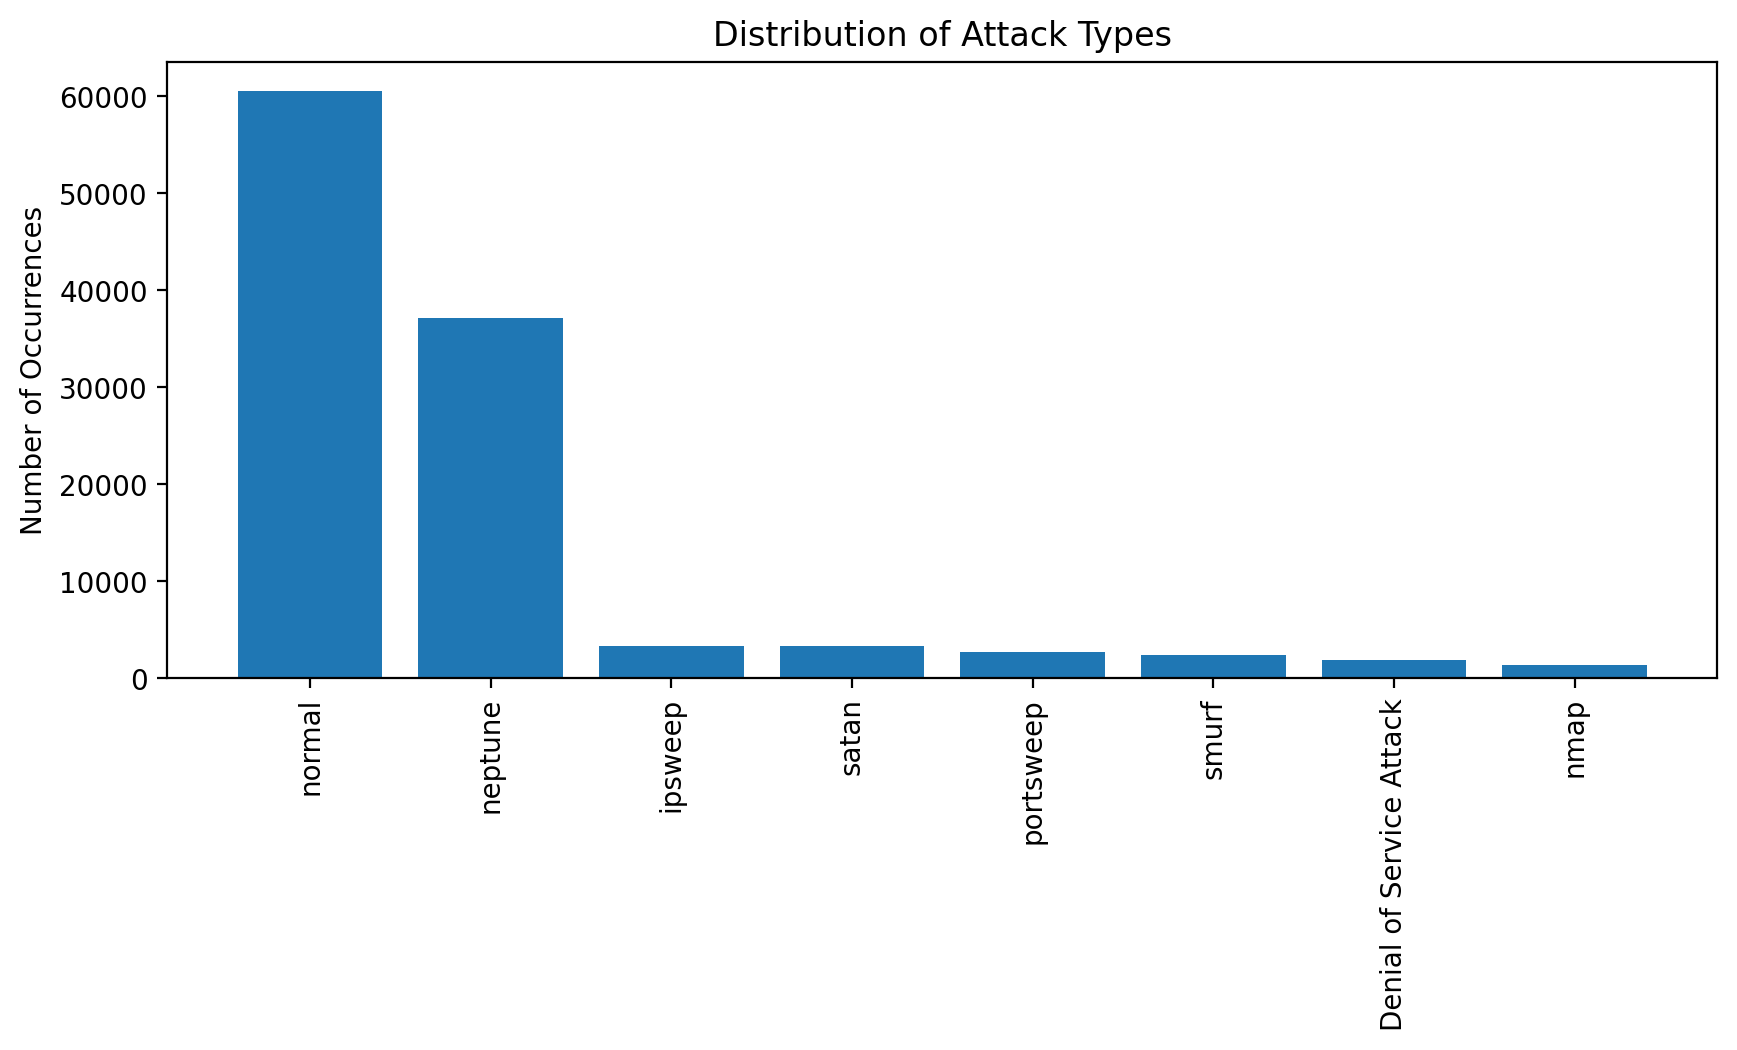

In [6]:
plt.figure(figsize=(10, 4), dpi=200)
plt.bar(df["type_of_attack"].value_counts().index, df["type_of_attack"].value_counts().values)
plt.title("Distribution of Attack Types")
plt.xlabel("")
plt.xticks(rotation=90)
plt.ylabel("Number of Occurrences")
plt.show()

### Data Preprocessing

Although this step is not mandatory for most model training, it becomes pertinent when visualizing decision trees, like those in XGBoost. Decision trees often have difficulty interpreting features with white spaces, so for clarity in visualization, we replace them with underscores.

In [7]:
# df = df.fillna(0)
df = df.replace(" ", "_", regex=True)
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack
0,0.0,tcp,private,SH,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.01,0.94,0.95,0.0,0.95,1.0,0.0,0.0,nmap
1,0.0,tcp,private,S0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.02,0.08,0.00,0.0,1.00,1.0,0.0,0.0,neptune
2,0.0,tcp,http,SF,285.0,3623.0,0.0,0.0,0.0,0.0,...,228.0,1.00,0.00,0.01,NaN,0.00,0.0,0.0,0.0,normal
3,0.0,tcp,http,SF,232.0,584.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.17,NaN,0.00,0.0,0.0,0.0,normal
4,1.0,tcp,smtp,SF,1080.0,327.0,0.0,0.0,0.0,0.0,...,154.0,0.58,0.02,0.00,NaN,0.00,0.0,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112441,0.0,tcp,http,REJ,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.14,NaN,0.00,0.0,NaN,NaN,normal
112442,0.0,tcp,http,SF,309.0,758.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.02,NaN,0.02,NaN,0.0,0.0,normal
112443,0.0,tcp,http,SF,363.0,721.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,normal
112444,0.0,tcp,discard,RSTO,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.03,0.06,0.00,0.0,0.00,0.0,1.0,1.0,neptune


We define our independent variables or features that will be used to train the model. These variables provide the input for our predictions.

In [8]:
X = df.drop("type_of_attack", axis=1).copy()
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,tcp,private,SH,0.0,0.0,0.0,0.0,0.0,0.0,...,176.0,1.0,0.01,0.94,0.95,0.0,0.95,1.0,0.0,0.0
1,0.0,tcp,private,S0,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,5.0,0.02,0.08,0.00,0.0,1.00,1.0,0.0,0.0
2,0.0,tcp,http,SF,285.0,3623.0,0.0,0.0,0.0,0.0,...,115.0,228.0,1.00,0.00,0.01,NaN,0.00,0.0,0.0,0.0
3,0.0,tcp,http,SF,232.0,584.0,0.0,0.0,0.0,0.0,...,6.0,255.0,1.00,0.00,0.17,NaN,0.00,0.0,0.0,0.0
4,1.0,tcp,smtp,SF,1080.0,327.0,0.0,0.0,0.0,0.0,...,202.0,154.0,0.58,0.02,0.00,NaN,0.00,0.0,0.0,0.0


Given the presence of categorical variables in our dataset, we apply one-hot encoding. This approach is preferred over label encoding as it doesn't inadvertently introduce a ranking amongst categories.

In [9]:
X_encoded = pd.get_dummies(X).astype(float)
X_encoded.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,285.0,3623.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,232.0,584.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1080.0,327.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Our target variable, `type_of_attack`, represents the outcome we aim to predict. This variable provides the labels for training and evaluation of our model.

In [10]:
y = df["type_of_attack"].copy()
y.head()

0       nmap
1    neptune
2     normal
3     normal
4     normal
Name: type_of_attack, dtype: object

To train our model efficiently, we convert the categorical target variable into numerical labels. This transformation allows our model to process the target variable seamlessly.

In [11]:
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)
y_encoded

array([3, 2, 4, ..., 4, 2, 4])

For future reference, we create a mapping that displays the relationship between the encoded labels and their original values.

In [12]:
df_encoding = pd.DataFrame({
    "Encoded_Label": range(len(label_encoder.classes_)),
    "Original_Label": label_encoder.classes_
})
df_encoding

,Encoded_Label,Original_Label
0,0,Denial_of_Service_Attack
1,1,ipsweep
2,2,neptune
3,3,nmap
4,4,normal
5,5,portsweep
6,6,satan
7,7,smurf


To evaluate our model's performance, we split the dataset into training and testing subsets. A stratified split ensures that the proportion of classes remains consistent in both subsets.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, random_state=42, test_size=0.3, stratify=y_encoded)

print(f"Training dataset\t: {len(X_train)}\t({round(len(X_train) / len(X) * 100)}%)")
print(f"Testing dataset\t\t: {len(X_test)}\t({round(len(X_test) / len(X) * 100)}%)")

Training dataset	: 78712	(70%)
Testing dataset		: 33734	(30%)


# Modeling

### Default

**XGBoost**

In [32]:
default_xgbm_model = xgboost.XGBClassifier(
    objective="multi:softmax",
    missing=np.nan,
    seed=random_state,
    eval_metric="mlogloss",
    early_stopping_rounds=10
)
default_xgbm_model.fit(
    X_train,
    y_train,
    verbose=True,
    eval_set=[(X_test, y_test)]
)

[0]	validation_0-mlogloss:1.04179
[1]	validation_0-mlogloss:0.71198
[2]	validation_0-mlogloss:0.50963
[3]	validation_0-mlogloss:0.37251
[4]	validation_0-mlogloss:0.27553
[5]	validation_0-mlogloss:0.20599
[6]	validation_0-mlogloss:0.15545
[7]	validation_0-mlogloss:0.11856
[8]	validation_0-mlogloss:0.09126
[9]	validation_0-mlogloss:0.07127
[10]	validation_0-mlogloss:0.05618
[11]	validation_0-mlogloss:0.04494
[12]	validation_0-mlogloss:0.03661
[13]	validation_0-mlogloss:0.03042
[14]	validation_0-mlogloss:0.02567
[15]	validation_0-mlogloss:0.02213
[16]	validation_0-mlogloss:0.01950
[17]	validation_0-mlogloss:0.01751
[18]	validation_0-mlogloss:0.01603
[19]	validation_0-mlogloss:0.01491
[20]	validation_0-mlogloss:0.01405
[21]	validation_0-mlogloss:0.01336
[22]	validation_0-mlogloss:0.01286
[23]	validation_0-mlogloss:0.01245
[24]	validation_0-mlogloss:0.01215
[25]	validation_0-mlogloss:0.01192
[26]	validation_0-mlogloss:0.01173
[27]	validation_0-mlogloss:0.01158
[28]	validation_0-mlogloss:0.0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [33]:
default_xgbm_pred = default_xgbm_model.predict(X_test)
accuracy_score(y_test, default_xgbm_pred)

0.9963834706823976

**LightGBM**

In [34]:
params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "seed": random_state,
    "early_stopping_round": 10
}

default_lgbm_model = lightgbm.LGBMClassifier(**params)
default_lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2451
[LightGBM] [Info] Number of data points in the train set: 78712, number of used features: 113
[LightGBM] [Info] Start training from score -4.101126
[LightGBM] [Info] Start training from score -3.542498
[LightGBM] [Info] Start training from score -1.107738
[LightGBM] [Info] Start training from score -4.443757
[LightGBM] [Info] Start training from score -0.619213
[LightGBM] [Info] Start training from score -3.733992
[LightGBM] [Info] Start training from score -3.544255
[LightGBM] [Info] Start training from score -3.849386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.0111915


LGBMClassifier(early_stopping_round=10, metric='multi_logloss',
               objective='multiclass', seed=42)

In [35]:
default_lgbm_pred = default_lgbm_model.predict(X_test)
accuracy_score(y_test, default_lgbm_pred)

0.9963241833165353

### Model Training

Before diving into hyperparameter optimization, it's advantageous to train a base model. By setting manual hyperparameters, we lay the groundwork for our XGBoost model. Given XGBoost's robustness, there's a high likelihood of achieving promising initial results. If the model performs well, we can avoid extensive hyperparameter tuning via methods like `GridSearchCV`, saving time and reducing the risk of overfitting. Notably, our model's training stopped at the 55th tree.

In [14]:
clf_xgb = xgb.XGBClassifier(
    objective="multi:softmax",
    missing=np.nan,
    seed=random_state,
    early_stopping_rounds=10,
    eval_metric="aucpr"
)
clf_xgb.fit(
    X_train,
    y_train,
    verbose=True,
    eval_set=[(X_test, y_test)]
)

[0]	validation_0-aucpr:0.96942
[1]	validation_0-aucpr:0.97722
[2]	validation_0-aucpr:0.97913
[3]	validation_0-aucpr:0.98078
[4]	validation_0-aucpr:0.98242
[5]	validation_0-aucpr:0.98349
[6]	validation_0-aucpr:0.98473
[7]	validation_0-aucpr:0.98503
[8]	validation_0-aucpr:0.98568
[9]	validation_0-aucpr:0.98587
[10]	validation_0-aucpr:0.98620
[11]	validation_0-aucpr:0.98628
[12]	validation_0-aucpr:0.98670
[13]	validation_0-aucpr:0.98676
[14]	validation_0-aucpr:0.98698
[15]	validation_0-aucpr:0.98707
[16]	validation_0-aucpr:0.98705
[17]	validation_0-aucpr:0.98733
[18]	validation_0-aucpr:0.98742
[19]	validation_0-aucpr:0.98746
[20]	validation_0-aucpr:0.98757
[21]	validation_0-aucpr:0.98768
[22]	validation_0-aucpr:0.98762
[23]	validation_0-aucpr:0.98771
[24]	validation_0-aucpr:0.98773
[25]	validation_0-aucpr:0.98778
[26]	validation_0-aucpr:0.98786
[27]	validation_0-aucpr:0.98786
[28]	validation_0-aucpr:0.98820
[29]	validation_0-aucpr:0.98825
[30]	validation_0-aucpr:0.98842
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

Using the trained XGBoost model, we predict the classes for our testing dataset.

In [15]:
y_pred = clf_xgb.predict(X_test)

### Model Evaluation

As an initial metric, we check the accuracy of our model. With an impressive accuracy score of ~99.64%, our model demonstrates substantial proficiency in classifying attack types.

In [16]:
accuracy_score(y_test, y_pred)

0.9963538269994664

The classification report offers an in-depth look at the model's performance across individual classes. It presents three primary metrics:

- `Precision`: The ratio of correctly predicted positive observations to the total predicted positives. High precision suggests that the false positive rate is low.
- `Recall`: The ratio of correctly predicted positive observations to all actual positives. It indicates how many of the actual positive cases we were able to capture with our model.
- `F1-Score`: A weighted average of precision and recall, which provides a balanced measure especially when the class distribution is skewed.

For illustration, consider the `ipsweep` class. It has a precision of 0.92, meaning 92% of instances predicted as `ipsweep` are indeed `ipsweep`. Its recall of 0.98 implies our model captures 98% of actual `ipsweep` instances. These numbers reflect a model that has strong predictive capabilities with minimal false positives for this class.

In [17]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

Denial_of_Service_Attack       1.00      1.00      1.00       558
                 ipsweep       0.92      0.98      0.95       976
                 neptune       1.00      1.00      1.00     11143
                    nmap       0.94      0.78      0.85       397
                  normal       1.00      1.00      1.00     18162
               portsweep       1.00      0.99      1.00       806
                   satan       1.00      1.00      1.00       974
                   smurf       1.00      1.00      1.00       718

                accuracy                           1.00     33734
               macro avg       0.98      0.97      0.97     33734
            weighted avg       1.00      1.00      1.00     33734



The confusion matrix is a powerful tool that visualizes the performance of an algorithm. Each row of the matrix represents the actual class, while each column stands for the predicted class.

- `Diagonal Elements`: Represent the count of correct predictions for a class.
- `Off-diagonal Elements`: Indicate misclassifications.

Using the `ipsweep` example from our matrix, our model correctly predicted 958 instances while misclassifying 18 as `nmap`. Furthermore, a quick glance at the matrix plot affirms the prowess of our XGBoost model. It not only correctly predicts the majority of instances across all classes but also exhibits finesse in handling minority classes, underscoring the model's robustness and capability.

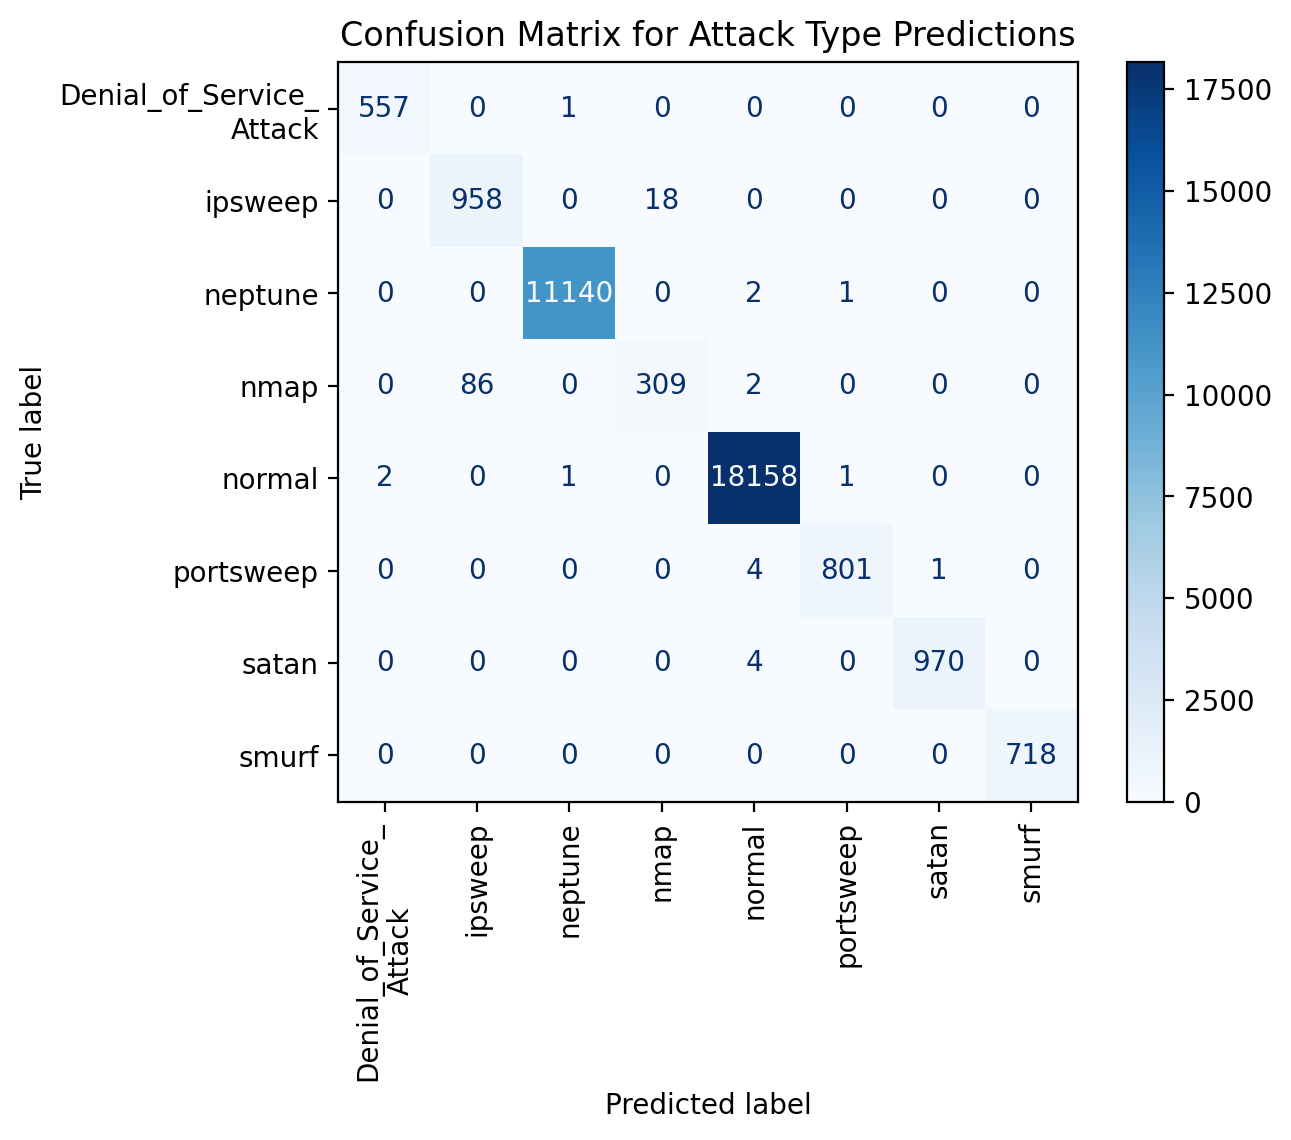

In [18]:
fig, ax = plt.subplots(dpi=200)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_, cmap="Blues", ax=ax)
ax.set_title("Confusion Matrix for Attack Type Predictions")

wrapper = textwrap.TextWrapper(width=18)

x_labels = ["\n".join(wrapper.wrap(label.get_text())) for label in ax.get_xticklabels()]
ax.set_xticklabels(x_labels, rotation=90)

y_labels = ["\n".join(wrapper.wrap(label.get_text())) for label in ax.get_yticklabels()]
ax.set_yticklabels(y_labels)

plt.show()

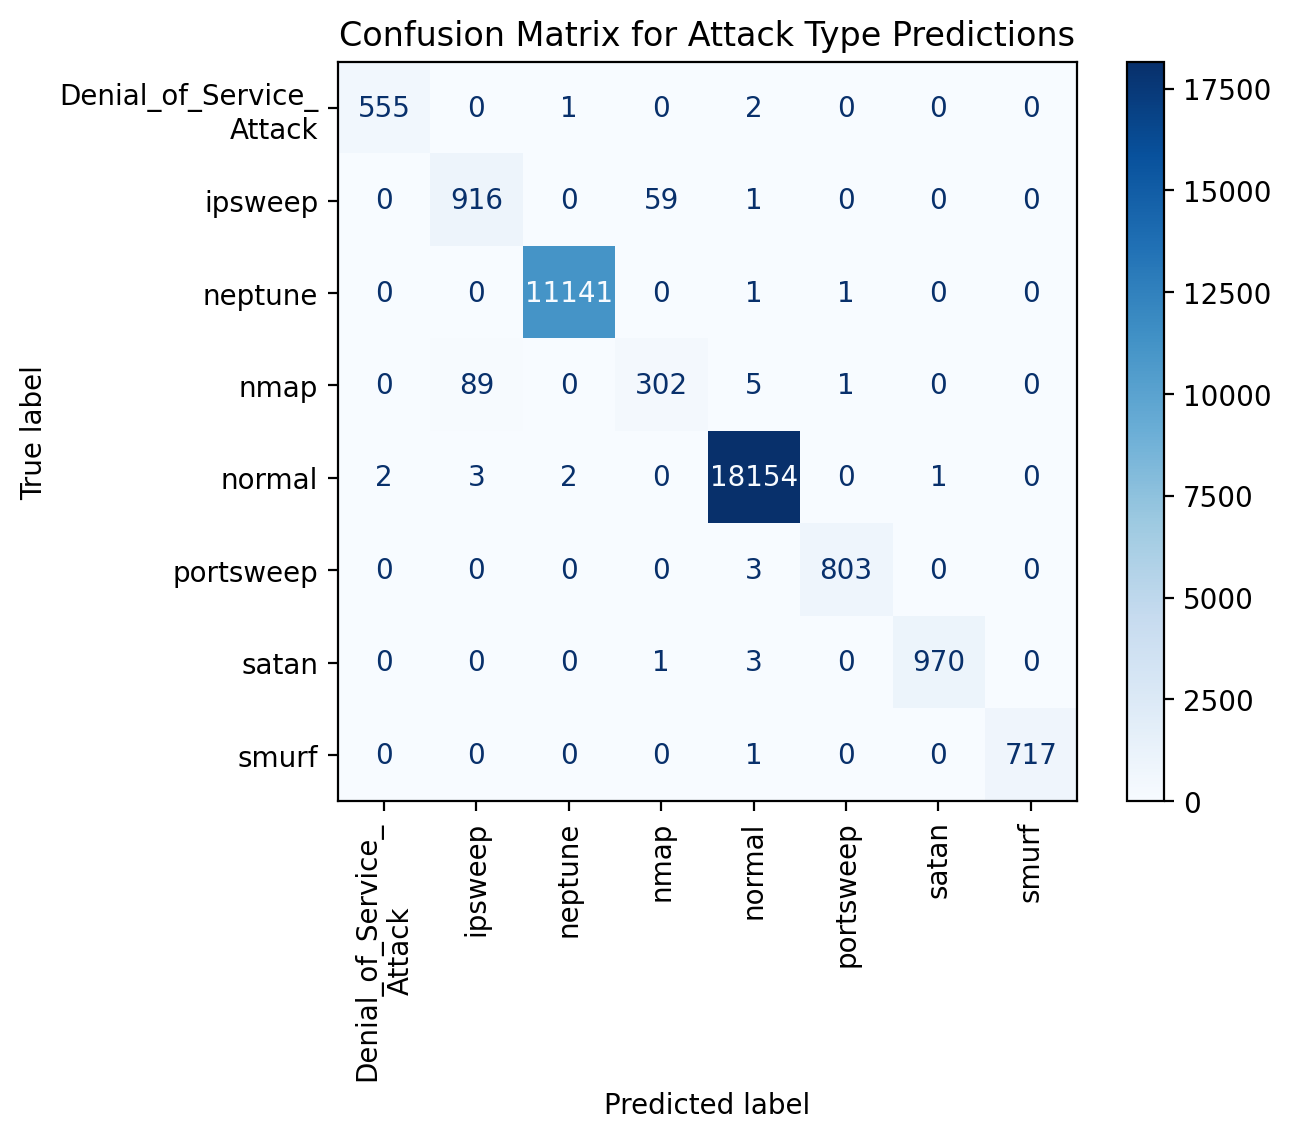

In [30]:
fig, ax = plt.subplots(dpi=200)
disp = ConfusionMatrixDisplay.from_predictions(y_test, pred_lgbm, display_labels=label_encoder.classes_, cmap="Blues", ax=ax)
ax.set_title("Confusion Matrix for Attack Type Predictions")

wrapper = textwrap.TextWrapper(width=18)

x_labels = ["\n".join(wrapper.wrap(label.get_text())) for label in ax.get_xticklabels()]
ax.set_xticklabels(x_labels, rotation=90)

y_labels = ["\n".join(wrapper.wrap(label.get_text())) for label in ax.get_yticklabels()]
ax.set_yticklabels(y_labels)

plt.show()

The Receiver Operating Characteristic (ROC) curve is a graphical representation that illustrates the diagnostic ability of a binary classifier as its discrimination threshold is varied. It plots the `True Positive Rate (TPR)` against the `False Positive Rate (FPR)`.

In an ideal scenario, we want the classifier to have a TPR of 1 and an FPR of 0, which means the curve would shoot straight up the y-axis and then to the right, forming a right-angle and covering the top-left area of the plot.

For multi-class classification, the ROC curve's implementation generally involves the one-vs-rest approach. In this method:

- For each class, the class is treated as positive while all other classes are considered negative.
- A binary ROC curve is plotted for each class.
- This process repeats for all classes, yielding multiple ROC curves.

The term one-vs-rest stems from the idea that, for each class, the class itself is treated as one category and all other classes combined are the rest.

Observing our multi-class ROC plot, we can discern that almost all lines (representing individual classes) are gravitating towards the top-left corner. This suggests an outstanding balance of sensitivity and specificity across all classes, indicating that our XGBoost model performs exceptionally well in distinguishing between classes.

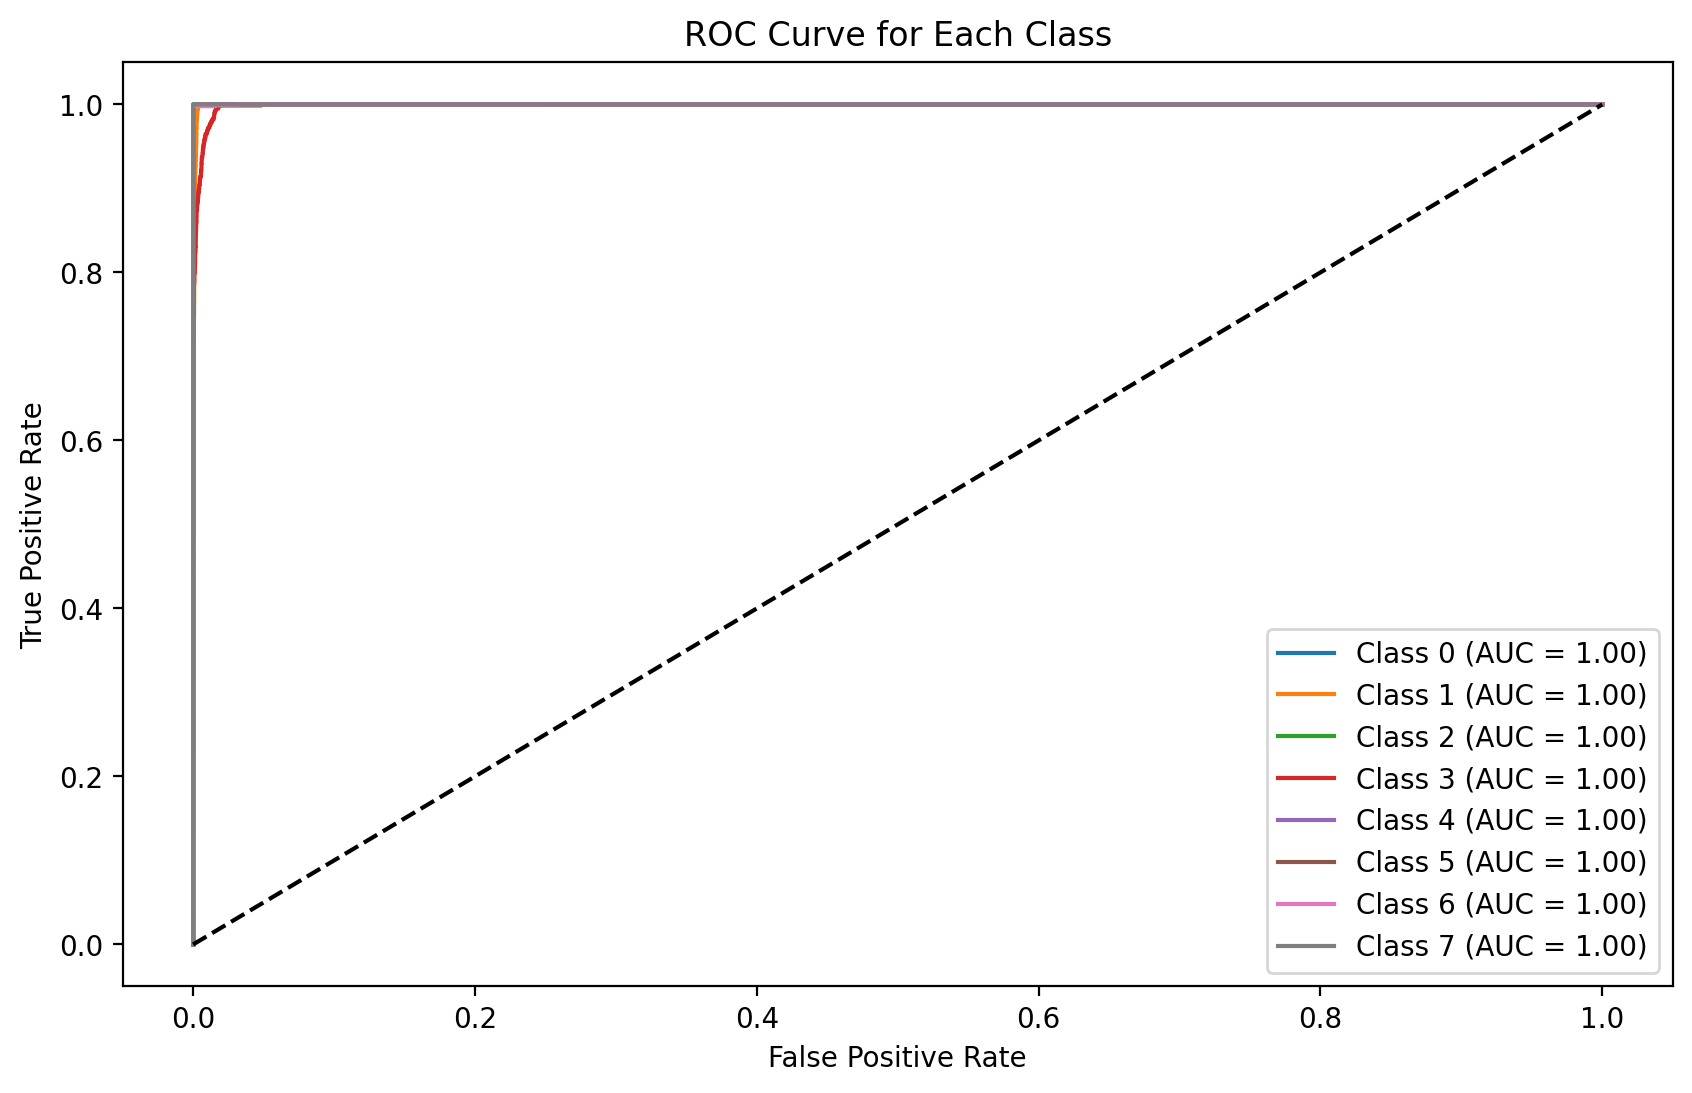

In [19]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

xgb_probs = clf_xgb.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 6), dpi=200)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], xgb_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()

The power of XGBoost stems from its ensemble of decision trees. Here, we visualize the first tree to understand its decisions better. Notably, XGBoost constructs subsequent trees based on the errors of previous ones. In our case, 55 such trees were formed.

weight:  {'duration': 6.0, 'src_bytes': 30.0, 'dst_bytes': 6.0, 'land': 1.0, 'wrong_fragment': 2.0, 'hot': 2.0, 'num_failed_logins': 2.0, 'logged_in': 2.0, 'num_compromised': 2.0, 'root_shell': 1.0, 'count': 12.0, 'srv_count': 6.0, 'rerror_rate': 6.0, 'srv_rerror_rate': 1.0, 'same_srv_rate': 2.0, 'diff_srv_rate': 2.0, 'dst_host_count': 13.0, 'dst_host_srv_count': 6.0, 'dst_host_same_srv_rate': 7.0, 'dst_host_diff_srv_rate': 5.0, 'dst_host_same_src_port_rate': 8.0, 'dst_host_srv_diff_host_rate': 1.0, 'dst_host_serror_rate': 3.0, 'dst_host_srv_serror_rate': 1.0, 'dst_host_rerror_rate': 4.0, 'protocol_type_icmp': 3.0, 'protocol_type_tcp': 1.0, 'protocol_type_udp': 2.0, 'service_domain_u': 1.0, 'service_eco_i': 3.0, 'service_ecr_i': 2.0, 'service_finger': 1.0, 'service_ftp_data': 1.0, 'service_http': 3.0, 'service_private': 3.0, 'service_smtp': 1.0, 'service_tim_i': 1.0, 'flag_OTH': 1.0, 'flag_REJ': 1.0, 'flag_RSTOS0': 1.0, 'flag_RSTR': 2.0, 'flag_S0': 2.0, 'flag_SH': 1.0}
gain:  {'duratio

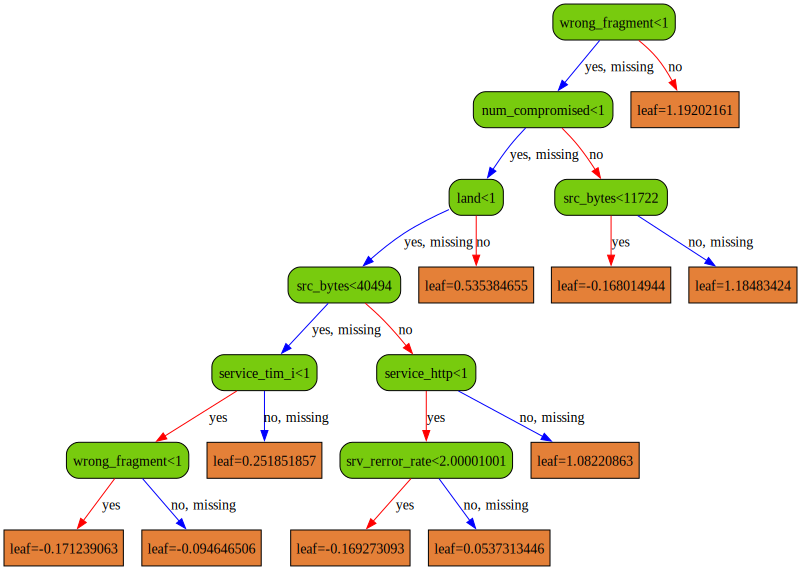

In [20]:
clf_xgb_first_tree = xgb.XGBClassifier(
    objective="multi:softmax",
    missing=np.nan,
    seed=random_state,
    early_stopping_rounds=10,
    eval_metric="aucpr",
    n_estimators=1
)
clf_xgb_first_tree.fit(
    X_train,
    y_train,
    verbose=False,
    eval_set=[(X_test, y_test)]
)

bst = clf_xgb_first_tree.get_booster()
for importance_type in ("weight", "gain", "cover", "total_gain", "total_cover"):
    print("%s: " % importance_type, bst.get_score(importance_type=importance_type))

node_params = {
    "shape": "box",
    "style": "filled, rounded",
    "fillcolor": "#78cbe"
}

leaf_params = {
    "shape": "box",
    "style": "filled",
    "fillcolor": "#e48038"
}

xgb.to_graphviz(
    clf_xgb_first_tree,
    num_trees=0,
    size="10,10",
    condition_node_params=node_params,
    leaf_node_params=leaf_params
)

Feature importance indicates which features were most influential in making a prediction. In XGBoost, this is calculated based on the number of times a feature appears in the trees of the model. Leading our feature importance chart is `diff_srv_rate` with a score of 0.33, emphasizing its significant role in our model's decisions.

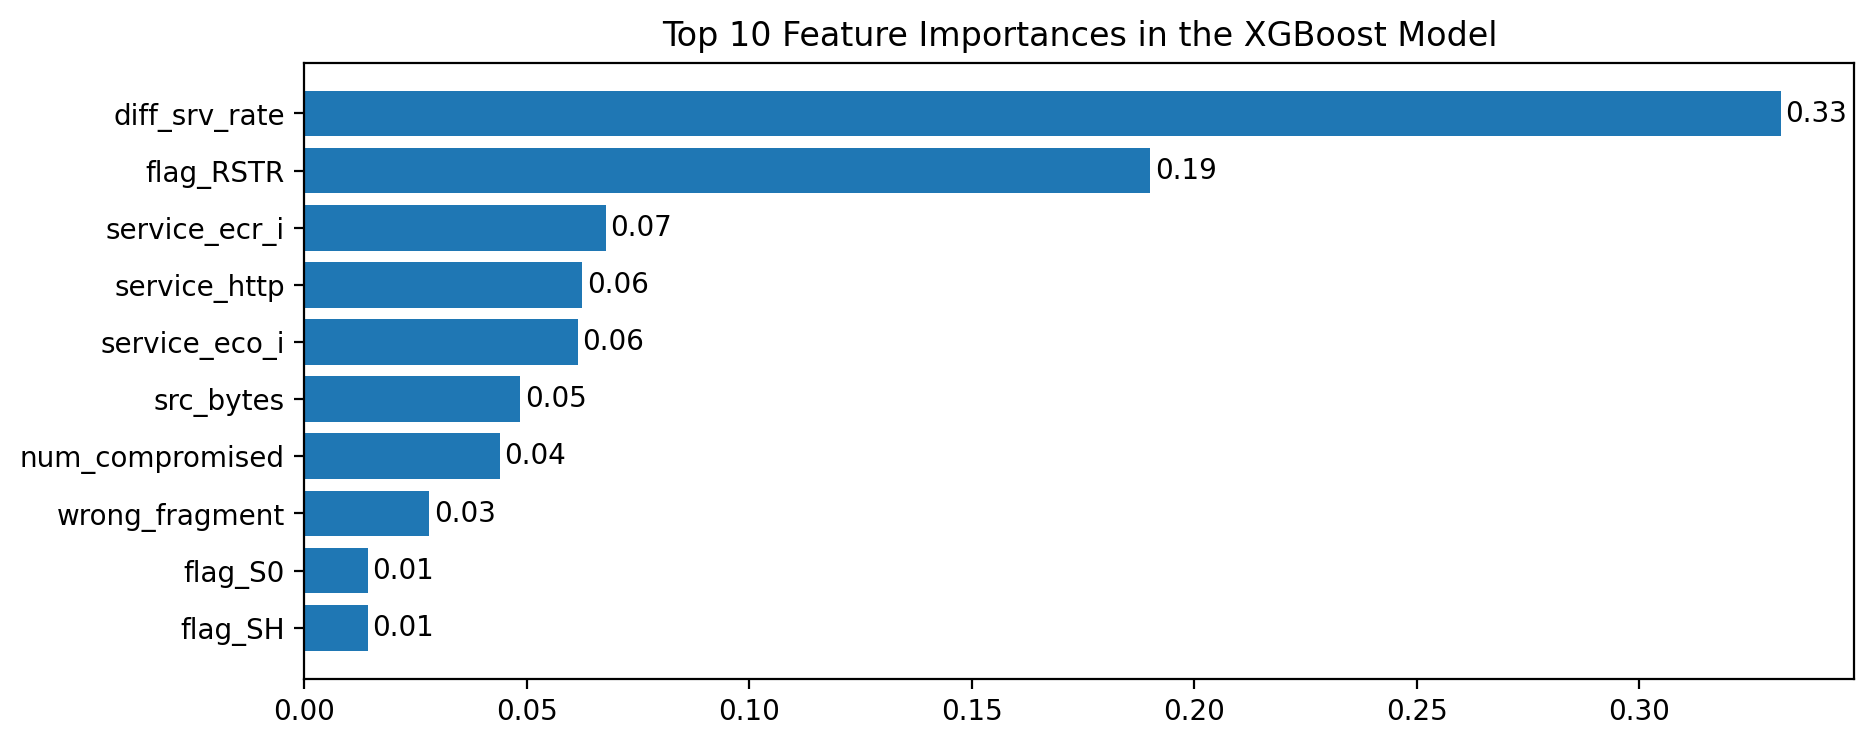

In [21]:
df_feature_importances = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Importance": clf_xgb.feature_importances_
})
df_feature_importances = df_feature_importances.sort_values("Importance").tail(10)

plt.figure(figsize=(10, 4), dpi=200)
bars = plt.barh(df_feature_importances["Feature"], df_feature_importances["Importance"])

for bar in bars:
    plt.text(
        bar.get_width() + 0.001,
        bar.get_y() + bar.get_height()/2, 
        f"{bar.get_width():.2f}", 
        va="center",
        ha="left",
        color="black")

plt.title("Top 10 Feature Importances in the XGBoost Model")
plt.show()

### Predicting on New Data

We need to load the new dataset, which doesn't contain our target variable. This dataset contains the instances we aim to predict with our trained model.

In [22]:
df_prediction = pd.read_csv("Data_Prediction - Copy.csv", delimiter=";")
df_prediction

,id,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,1,1,tcp,smtp,SF,2397,328,0,0,0,...,179,182,0.68,0.02,0.01,0.01,0.0,0.0,0.0,0.0
1,2,990,udp,other,SF,145,105,0,0,0,...,255,1,0.00,0.64,0.94,0.00,0.0,0.0,0.0,0.0
2,3,0,icmp,ecr_i,SF,1032,0,0,0,0,...,255,23,0.09,0.02,0.09,0.00,0.0,0.0,0.0,0.0
3,4,0,icmp,eco_i,SF,8,0,0,0,0,...,1,85,1.00,0.00,1.00,0.51,0.0,0.0,0.0,0.0
4,5,0,udp,domain_u,SF,44,132,0,0,0,...,250,101,0.40,0.01,0.38,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12474,12475,0,tcp,http,SF,320,1673,0,0,0,...,127,255,1.00,0.00,0.01,0.06,0.0,0.0,0.0,0.0
12475,12476,21410,tcp,private,RSTR,1,0,0,0,0,...,255,2,0.01,0.69,1.00,0.00,0.0,0.0,1.0,1.0
12476,12477,1,tcp,smtp,SF,743,371,0,0,0,...,6,207,1.00,0.00,0.17,0.01,0.0,0.0,0.0,0.0
12477,12478,0,icmp,eco_i,SF,8,0,0,0,0,...,4,168,1.00,0.00,1.00,0.25,0.0,0.0,0.0,0.0


We need to ensure that there are no missing value indicators (`*` and `99999`) in our new dataset.

In [23]:
df_prediction[df_prediction.isin(["*", "99999"]).any(axis=1)]

,id,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate


Before making predictions, it's essential to ensure that the new data's features match the format used during the training of our XGBoost model. This involves one-hot encoding the categorical variables and ensuring the new dataset has the same feature columns as the training set.

In [24]:
df_prediction_encoded = pd.get_dummies(df_prediction.drop("id", axis=1)).astype(float)

for col in X_encoded.columns:
    if col not in df_prediction_encoded.columns:
        df_prediction_encoded[col] = 0

df_prediction_encoded = df_prediction_encoded[X_encoded.columns]

df_prediction_encoded

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,1.0,2397.0,328.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,990.0,145.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,44.0,132.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12474,0.0,320.0,1673.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12475,21410.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12476,1.0,743.0,371.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12477,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


To ensure we haven't introduced any discrepancies, we'll compare columns from the encoded new dataset and our original encoded features.

In [25]:
for col1, col2 in zip(df_prediction_encoded.columns, X_encoded.columns):
    print(f"{col1} | {col2}")

duration | duration
src_bytes | src_bytes
dst_bytes | dst_bytes
land | land
wrong_fragment | wrong_fragment
urgent | urgent
hot | hot
num_failed_logins | num_failed_logins
logged_in | logged_in
num_compromised | num_compromised
root_shell | root_shell
su_attempted | su_attempted
num_root | num_root
num_file_creations | num_file_creations
num_shells | num_shells
num_access_files | num_access_files
num_outbound_cmds | num_outbound_cmds
is_host_login | is_host_login
is_guest_login | is_guest_login
count | count
srv_count | srv_count
serror_rate | serror_rate
srv_serror_rate | srv_serror_rate
rerror_rate | rerror_rate
srv_rerror_rate | srv_rerror_rate
same_srv_rate | same_srv_rate
diff_srv_rate | diff_srv_rate
srv_diff_host_rate | srv_diff_host_rate
dst_host_count | dst_host_count
dst_host_srv_count | dst_host_srv_count
dst_host_same_srv_rate | dst_host_same_srv_rate
dst_host_diff_srv_rate | dst_host_diff_srv_rate
dst_host_same_src_port_rate | dst_host_same_src_port_rate
dst_host_srv_diff_

Now that our data is formatted appropriately, we can make predictions. After obtaining the predictions as integers, we'll convert them back to their original string labels using our earlier created mapping.

In [26]:
label_mapping = dict(zip(df_encoding["Encoded_Label"], df_encoding["Original_Label"]))

new_pred = clf_xgb.predict(df_prediction_encoded)
new_pred = np.vectorize(label_mapping.get)(new_pred)
new_pred = [label.replace("_", " ") for label in new_pred]

Now, we'll add our predictions to the new dataset as the type_of_attack column.

In [27]:
df_prediction["type_of_attack"] = new_pred
df_prediction

,id,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack
0,1,1,tcp,smtp,SF,2397,328,0,0,0,...,182,0.68,0.02,0.01,0.01,0.0,0.0,0.0,0.0,normal
1,2,990,udp,other,SF,145,105,0,0,0,...,1,0.00,0.64,0.94,0.00,0.0,0.0,0.0,0.0,normal
2,3,0,icmp,ecr_i,SF,1032,0,0,0,0,...,23,0.09,0.02,0.09,0.00,0.0,0.0,0.0,0.0,smurf
3,4,0,icmp,eco_i,SF,8,0,0,0,0,...,85,1.00,0.00,1.00,0.51,0.0,0.0,0.0,0.0,ipsweep
4,5,0,udp,domain_u,SF,44,132,0,0,0,...,101,0.40,0.01,0.38,0.00,0.0,0.0,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12474,12475,0,tcp,http,SF,320,1673,0,0,0,...,255,1.00,0.00,0.01,0.06,0.0,0.0,0.0,0.0,normal
12475,12476,21410,tcp,private,RSTR,1,0,0,0,0,...,2,0.01,0.69,1.00,0.00,0.0,0.0,1.0,1.0,portsweep
12476,12477,1,tcp,smtp,SF,743,371,0,0,0,...,207,1.00,0.00,0.17,0.01,0.0,0.0,0.0,0.0,normal
12477,12478,0,icmp,eco_i,SF,8,0,0,0,0,...,168,1.00,0.00,1.00,0.25,0.0,0.0,0.0,0.0,nmap


To facilitate sharing or submission, we'll export the predictions to a `.txt` file.

In [28]:
with open("predictions.txt", "w") as file:
    for prediction in new_pred:
        file.write(prediction + "\n")